# With sWeights: `common_B0TODstDs_Dst_constr`
# Without sWeights: `common_B0TODst3pi_Dst_constr`
# Fit the complete data (With sWeights and without sWeights)
- Fit to the $_s$Weithed $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ with $m(3\pi)$ in a region of $\pm 50\ MeV/c^2$ around $m(D_s)$
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit to $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
        - **FINAL CHOICE: $\alpha_L$, $\alpha_R$, $n_L$ free, $n_R$ fixed**
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Combinatorial background (exponential)

- Computation of $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$ and comparison with the ratio of PDG branching ratio
- Computation of $\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}$ and comparison with the ratio of PDG branching ratio. Computation of the rate of misidentified $K$ as $\pi$

Those two fits are not simultaneous. The sWeights are computed in `1_compute_sWeights_common.ipynb` with the `hepstats` library

In [8]:
data_name_MC = 'MC_constr_opposedCB_sharedMean'
data_name_KPiPi = "data_KPiPi_constr"

data_name = 'common_B0TODst3pi_Dst_constr'
data_name_B0toDstDs = 'common_B0TODstDs_Dst_constr'
data_name_Dstto3pi = 'common_DstTO3pi'

In [9]:
branch = 'Dst_constr_B0_M'

In [10]:
low_DstDs = 5150.
high_DstDs = 5350.

In [11]:
low = 5150.
high = 5545.

## Import

In [12]:
import zfit
import timeit
import pandas as pd
import numpy as np


from bd2dst3pi.locations import loc
from bd2dst3pi.definition import years, magnets, latex_params, latex_params_B0toDstDs
from bd2dst3pi.pandas_root import load_data, add_constr_Dst

import sys
sys.path.append(loc.ROOT + 'library/')

from HEA.plot import plot_hist_auto, plot_hist, plot_hist2d_auto
from HEA.plot.fit import plot_hist_fit_auto
from HEA.fit import json_to_latex_table, retrieve_params, show_latex_table
from HEA.fit.fit import launch_fit, save_params, define_zparams, sum_crystalball_or_gaussian, check_fit
from HEA.tools import show_dictionnary
from HEA.plot.tools import save_fig, show_grid
from HEA.tools.serial import dump_pickle
from HEA.pandas_root import save_root, load_saved_root

## Load

In [13]:
df = load_data(years, magnets, type_data='common', vars=['B0_M'],
                            cut_DeltaM=True)

Loading /eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
Loading /eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
Loading /eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
Loading /eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
Delta_M > 143. and Delta_M < 148. cut has removed 425088 over 935261 events


### Constrained data

In [14]:
df = add_constr_Dst(df)

## Fit to the $_s$Weighted $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ with `|tau_M-1969|<50`

### Data

In [15]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_DstDs = load_saved_root(data_name_Dstto3pi, [branch, 'sWeight'], folder_name='common')

Loading /afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_DstTO3pi.root


### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/library/HEA/plot/histogram.py:84: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODstDs_Dst_constr/Dst_constr_B0_M_common_B0TODstDs_Dst_constr


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

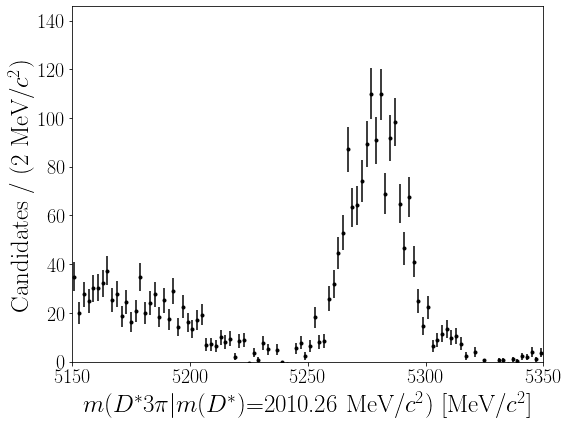

In [16]:
plot_hist_auto({data_name_B0toDstDs:df_DstDs}, branch,
              low = low_DstDs, high=high_DstDs,
              n_bins=100, bar_mode=False, colors='black', weights=df_DstDs['sWeight'])


### Starting values

In [17]:
n_events_DstDs = len(df_DstDs.query(f'{branch} > {low_DstDs} and {branch} < {high_DstDs}'))

n_sig_k = 1600
n_bkg_k = 300
n_bkg2_k = 700

initial_values_DstDs = {
    # Signal
    'mu_DstDs'       :{ 'value': 5280.                         , 'low': 5280.-4.       , 'high': 5280.+4.             , 'floating': True},
    'sigma_DstDs'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_DstDs'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_DstDs       , 'floating': True},
    # Combinatorial background
    'lambda_DstDs'   :{ 'value': -0.005                       , 'low': -0.1           , 'high': -0.00000000000000001  , 'floating': True},
    'n_bkg_DstDs'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_DstDs       , 'floating': True},
    # Partially reconstructed particles
    'mu2_DstDs'      :{ 'value': 5150                          , 'low': 4800.          , 'high': 5200.                , 'floating': True},
    'sigma2_DstDs'   :{ 'value': 40.                           , 'low': 10.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_DstDs'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_DstDs       , 'floating': True},
}

### Observables and variables

In [15]:
obs_DstDs = zfit.Space("x", limits=(low_DstDs, high_DstDs))

zparams_DstDs = define_zparams(initial_values_DstDs)

### PDFs

In [17]:
gaussianS_DstDs = zfit.pdf.Gauss(zparams_DstDs['mu_DstDs'],zparams_DstDs['sigma_DstDs'],obs=obs_DstDs)
exponential_DstDs = zfit.pdf.Exponential(zparams_DstDs['lambda_DstDs'], obs=obs_DstDs)
gaussian_DstDs = zfit.pdf.Gauss(zparams_DstDs['mu2_DstDs'],zparams_DstDs['sigma2_DstDs'],obs=obs_DstDs)

gaussianS_DstDs_ext = gaussianS_DstDs.create_extended(zparams_DstDs['n_sig_DstDs'])
exponential_DstDs_ext = exponential_DstDs.create_extended(zparams_DstDs['n_bkg_DstDs'])
gaussian_DstDs_ext = gaussian_DstDs.create_extended(zparams_DstDs['n_bkg2_DstDs'])

model_DstDs = zfit.pdf.SumPDF([gaussianS_DstDs_ext, exponential_DstDs_ext, gaussian_DstDs_ext])
data_DstDs = zfit.Data.from_pandas(df_DstDs[branch], obs=obs_DstDs, weights=df_DstDs['sWeight'])

### Fitting

In [18]:
start = timeit.default_timer()
result_DstDs, params_DstDs = launch_fit(model_DstDs, data_DstDs, extended=True)
result_DstDs, params_DstDs = launch_fit(model_DstDs, data_DstDs, extended=True)
result_DstDs, params_DstDs = launch_fit(model_DstDs, data_DstDs, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4521                   |     Ncalls=330 (330 total)     |
| EDM = 5.37e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name               value    minuit_hesse    at limit
------------  ----------  --------------  ----------
n_sig_DstDs         1468     +/-      43       False
n_bkg_DstDs        88.44     +/-      60       False
n_bkg2_DstDs       714.8     +/-      42       False
mu_DstDs            5279     +/-    0.52       False
sigma_DstDs        12.35     +/-    0.47       False
lambda_DstDs  -3.815e-08     +/- 7.7e-07       False
mu2_DstDs           5167     +/-     3.5       False
sigma2_DstDs       27.87     +/-     2.6       False
------------------------------------------------------------------
| FCN = -4521                   |     Ncalls=112 (112 total)     |
| EDM = 1.39e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
-

### Plotting and saving

/afs/cern.ch/user/c/correian/bd2dst3pi/library/HEA/plot/fit.py:761: UserWarning: The function <function Space.limits at 0x7f3ab8a40d40> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5350.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/library/HEA/plot/histogram.py:84: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Number of bins: 100
Width of the bins: 2.0

Number of d.o.f. in the model:  8
Reduced chi2:  3.527043887592114

Mean of the normalised residuals: -0.03217473980882711
Std of the normalised residuals: 1.4785666505783908


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODstDs_Dst_constr/Dst_constr_B0_M_common_B0TODstDs_Dst_constr_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=3.53)', ylabel='residuals / $\\sigma$'>)

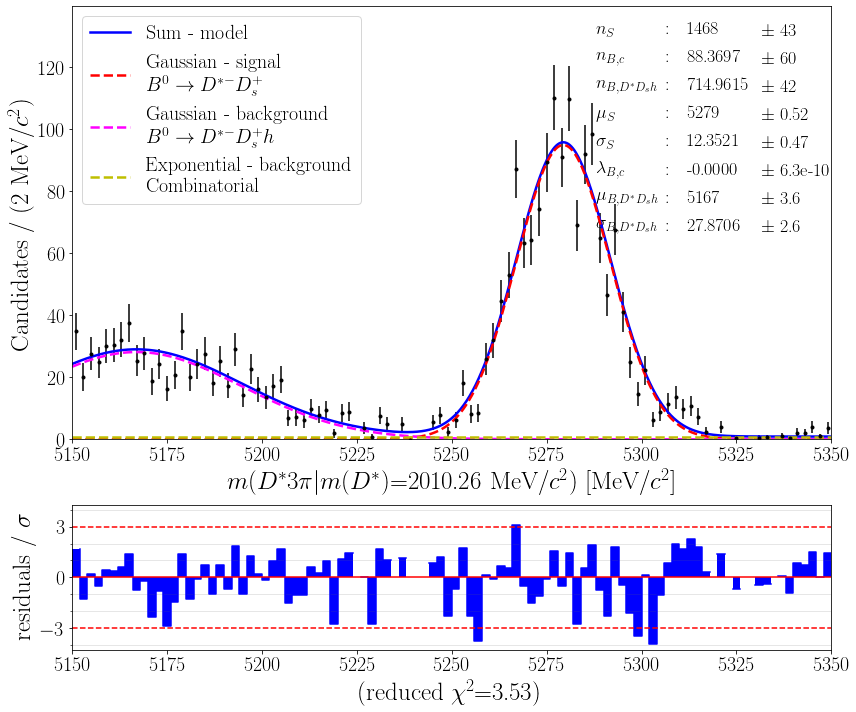

In [19]:
plot_hist_fit_auto(df_DstDs, branch, models = [model_DstDs, gaussianS_DstDs_ext, gaussian_DstDs_ext, exponential_DstDs_ext],
                       models_names = ["", '\n $B^0\\to D^{*-}D_s^+$','\n $B^0\\to D^{*-}D_s^+ h$',
                                      '\n Combinatorial'],
                       obs=obs_DstDs, n_bins = 100, bar_mode = False,
                       data_name=data_name_B0toDstDs+'_details', folder_name=data_name_B0toDstDs,
                       colors=['b','r','magenta','y'], weights=df_DstDs['sWeight'],
                       params=params_DstDs,latex_params=latex_params_B0toDstDs,
                       colWidths=[0.05,0.01,0.05,0.04], show_chi2=True,
                       fontsize_res = 18.,
                       fontsize_leg=20)

/afs/cern.ch/user/c/correian/bd2dst3pi/library/HEA/plot/histogram.py:84: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Number of bins: 40
Width of the bins: 5.0

Number of d.o.f. in the model:  8
Reduced chi2:  3.9039854864227097

Mean of the normalised residuals: 0.04217035197197531
Std of the normalised residuals: 1.3338623779174532


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODstDs_Dst_constr/Dst_constr_B0_M_common_B0TODstDs_Dst_constr_50_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (5 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

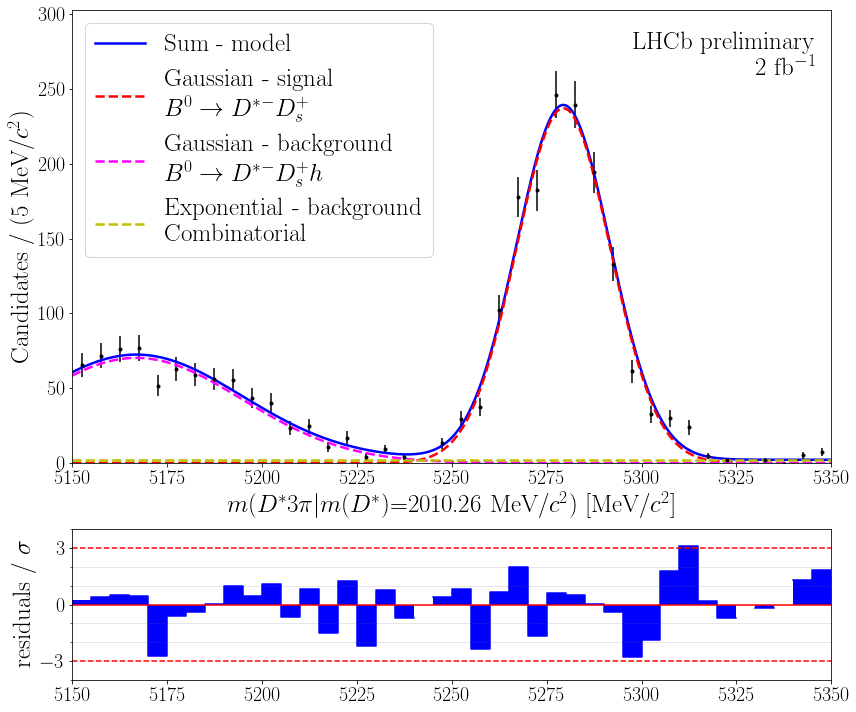

In [20]:
plot_hist_fit_auto(df_DstDs, branch, models = [model_DstDs, gaussianS_DstDs_ext, gaussian_DstDs_ext, exponential_DstDs_ext],
                       models_names = ["", '\n $B^0\\to D^{*-}D_s^+$','\n $B^0\\to D^{*-}D_s^+ h$',
                                      '\n Combinatorial'],
                       obs=obs_DstDs, n_bins = 40, bar_mode = False,
                       data_name = data_name_B0toDstDs+'_50', folder_name=data_name_B0toDstDs,
                       colors=['b','r','magenta','y'], weights=df_DstDs['sWeight'],
                       fontsize_res = 18., pos_text_LHC='right',
                       fontsize_leg=25)

In [21]:
save_params(params_DstDs, data_name_B0toDstDs, True, folder_name=data_name_B0toDstDs)

Json file saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/test/common_B0TODstDs_Dst_constr_params.json


### Latex table

In [22]:
json_to_latex_table(data_name_B0toDstDs, data_name_B0toDstDs, latex_params_B0toDstDs)

Latex table in /afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0TODstDs_Dst_constr/common_B0TODstDs_Dst_constr_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\lambda_{B,c}$&$(-0.0\pm6.3)e-10$\\
\hline
$\mu_{B, D^* D_s h}$&$5166.9\pm3.6$\\
\hline
$\mu_S$&$5279.40\pm0.52$\\
\hline
$n_{B, D^* D_s h}$&$715\pm42$\\
\hline
$n_{B,c}$&$88\pm60$\\
\hline
$n_S$&$1468\pm43$\\
\hline
$\sigma_{B, D^* D_s h}$&$27.9\pm2.6$\\
\hline
$\sigma_S$&$12.35\pm0.47$\\
\hline
\end{tabular}


In [24]:
fitted_params_DstDs = retrieve_params(data_name_B0toDstDs, folder_name=data_name_B0toDstDs)
show_dictionnary(fitted_params_DstDs)

lambda_DstDs: -2.450817326860033e-14
lambda_DstDs_err: 6.32539475263724e-10
mu2_DstDs: 5166.92246941216
mu2_DstDs_err: 3.564726441397587
mu_DstDs: 5279.404805713331
mu_DstDs_err: 0.5189594392943495
n_bkg2_DstDs: 714.96147795607
n_bkg2_DstDs_err: 41.5254578939308
n_bkg_DstDs: 88.36973871278974
n_bkg_DstDs_err: 60.34075807432827
n_sig_DstDs: 1467.9276079639549
n_sig_DstDs_err: 42.66355480246359
sigma2_DstDs: 27.870637119013594
sigma2_DstDs_err: 2.635996993619055
sigma_DstDs: 12.352082664623268
sigma_DstDs_err: 0.4720630376335545


## Fit to $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ in data

### Data

In [8]:
data_KPiPi_params = retrieve_params(data_name_KPiPi, folder_name='data_KPiPi') # already in MeV   
data_DstDs_params = retrieve_params(data_name_B0toDstDs, folder_name=data_name_B0toDstDs)   
MC_param_results = retrieve_params(data_name_MC, folder_name='MC') 

### Distribution

Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (3.95 MeV/$c^2$)'>)

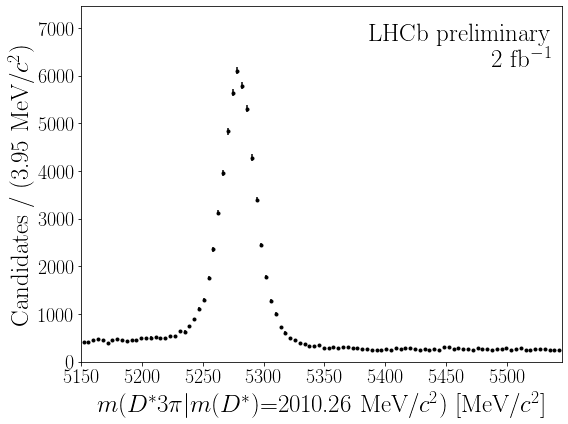

In [9]:
plot_hist_auto({data_name:df}, branch,
              low = low, high = high,
              n_bins = 100, bar_mode = False, colors='black', pos_text_LHC='right')

### Initial values

In [10]:
data_DstDs_params

{'lambda_DstDs': -2.450817326860033e-14,
 'lambda_DstDs_err': 6.32539475263724e-10,
 'mu2_DstDs': 5166.92246941216,
 'mu2_DstDs_err': 3.564726441397587,
 'mu_DstDs': 5279.404805713331,
 'mu_DstDs_err': 0.5189594392943495,
 'n_bkg2_DstDs': 714.96147795607,
 'n_bkg2_DstDs_err': 41.5254578939308,
 'n_bkg_DstDs': 88.36973871278974,
 'n_bkg_DstDs_err': 60.34075807432827,
 'n_sig_DstDs': 1467.9276079639549,
 'n_sig_DstDs_err': 42.66355480246359,
 'sigma2_DstDs': 27.870637119013594,
 'sigma2_DstDs_err': 2.635996993619055,
 'sigma_DstDs': 12.352082664623268,
 'sigma_DstDs_err': 0.4720630376335545}

In [11]:
n_events_Dst3pi_M = len(df.query(f'{branch} > {low} and {branch} < {high}'))

n_sig_k = 54000
n_bkg_k = 27000
r_bkgK_k = 0.03
initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-3.       , 'high': 5279.+3.             , 'floating': True},
    'sigmaL'   :{ 'value': 11.                           , 'low': 5.             , 'high': 15.                  , 'floating': True},
    'sigmaR'   :{ 'value': 19.                           , 'low': 15.            , 'high': 25.                  , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': True},
    'alphaR'   :{ 'value': MC_param_results['alphaR_MC'] , 'low': -10.           , 'high': -0.1                 , 'floating': True},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 10.                  , 'floating': True},
    'nR'       :{ 'value': MC_param_results['nR_MC']      , 'low': 1.             , 'high': 70.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1            , 'high': 1.                   , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_Dst3pi_M    , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.00003                      , 'low': -0.001         , 'high': -0.000001            , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_Dst3pi_M    , 'floating': True},
    # Background decay D*Kpipi    
    'r_bkgK'   :{ 'value': r_bkgK_k                      , 'low': 0.0001          , 'high': 0.08                , 'floating': True},
}

for variable in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{variable}_K'] = {'value': data_KPiPi_params[variable], 'low': None, 'high': None, 'floating': False}

for variable in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{variable}_Ds'] = {'value': data_DstDs_params[f'{variable}_DstDs'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [12]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

### PDFs

In [13]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball_or_gaussian(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball_or_gaussian(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_Ds_ext = gaussian_Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df[branch], obs=obs)

### Fit

In [14]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)

stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.312e+05              |     Ncalls=950 (950 total)     |
| EDM = 0.000742 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse    at limit
------  ----------  --------------  ----------
n_sig        54490     +/- 1.2e+03       False
r_bkgK     0.03535     +/-   0.015       False
n_bkg   

**$\alpha_L$, $\alpha_R$, $n_L$ free**: ok 

**All free**: unstable

**$\alpha_L$, $\alpha_R$, $\alpha_L$ free**: Hesse matrix not pos. def. 

/afs/cern.ch/user/c/correian/bd2dst3pi/library/HEA/plot/fit.py:761: UserWarning: The function <function Space.limits at 0x7faf9d95ee60> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5545.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])


Number of bins: 100
Width of the bins: 3.9499999999989086

Number of d.o.f. in the model:  11
Reduced chi2:  1.2175071260230974

Mean of the normalised residuals: -0.01493672036622347
Std of the normalised residuals: 1.0408449627803642


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (3.95 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

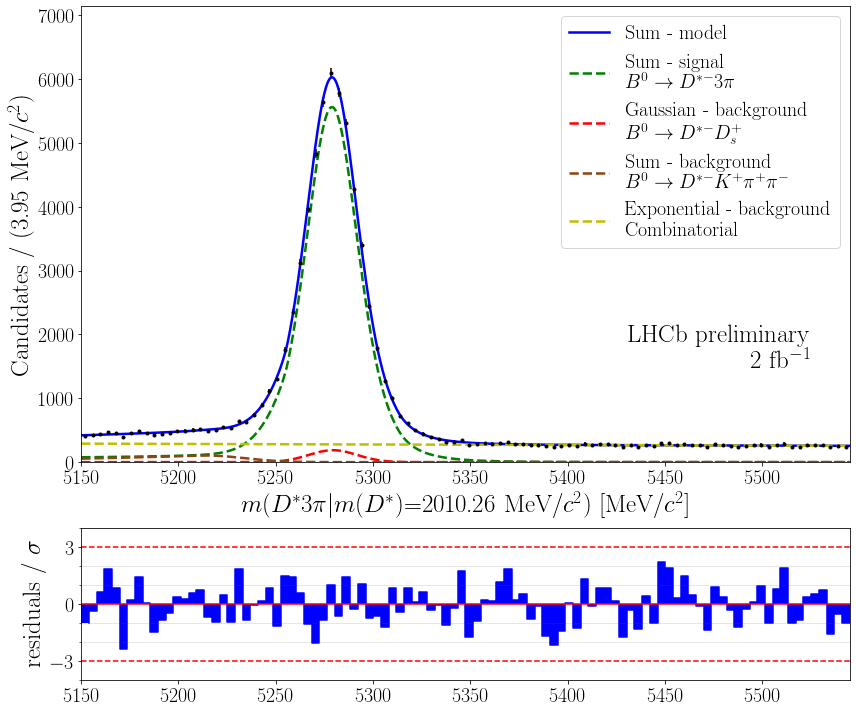

In [15]:
data_name_plot = data_name
plot_hist_fit_auto(df, branch, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      models_names = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,bar_mode = False, bar_mode_pull=True, 
                       data_name = data_name_plot, folder_name=data_name,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

Number of bins: 246
Width of the bins: 1.6056910569113825

Number of d.o.f. in the model:  11
Reduced chi2:  1.0797528637271598

Mean of the normalised residuals: -0.04069812864983221
Std of the normalised residuals: 1.0147979571982202
Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (1.61 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

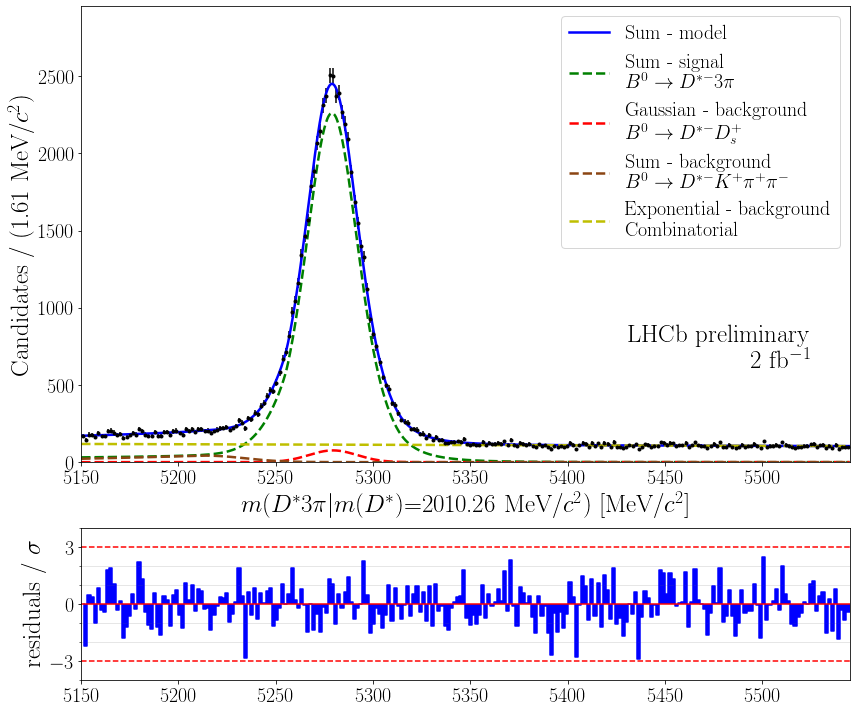

In [16]:
data_name_plot = data_name
plot_hist_fit_auto(df, branch, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      models_names = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 246,bar_mode = False, bar_mode_pull=True,
                       data_name = data_name_plot, folder_name=data_name,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

Number of bins: 198
Width of the bins: 1.9949494949487416

Number of d.o.f. in the model:  11
Reduced chi2:  1.0646865802252445

Mean of the normalised residuals: -0.03420608108297324
Std of the normalised residuals: 1.0021812559538477
Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_2_fit
Number of bins: 100
Width of the bins: 3.9499999999989086

Number of d.o.f. in the model:  11
Reduced chi2:  1.2175071260230974

Mean of the normalised residuals: -0.01493672036622347
Std of the normalised residuals: 1.0408449627803642
Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_4_fit
Number of bins: 49
Width of the bins: 8.061224489795677

Number of d.o.f. in the model:  11
Reduced chi2:  1.460566874741221

Mean of the normalised residuals: 0.04010357824253442
Std of the normalised residuals: 1.063520671222511

(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^*3\\pi|m(D^*)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (8.06 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

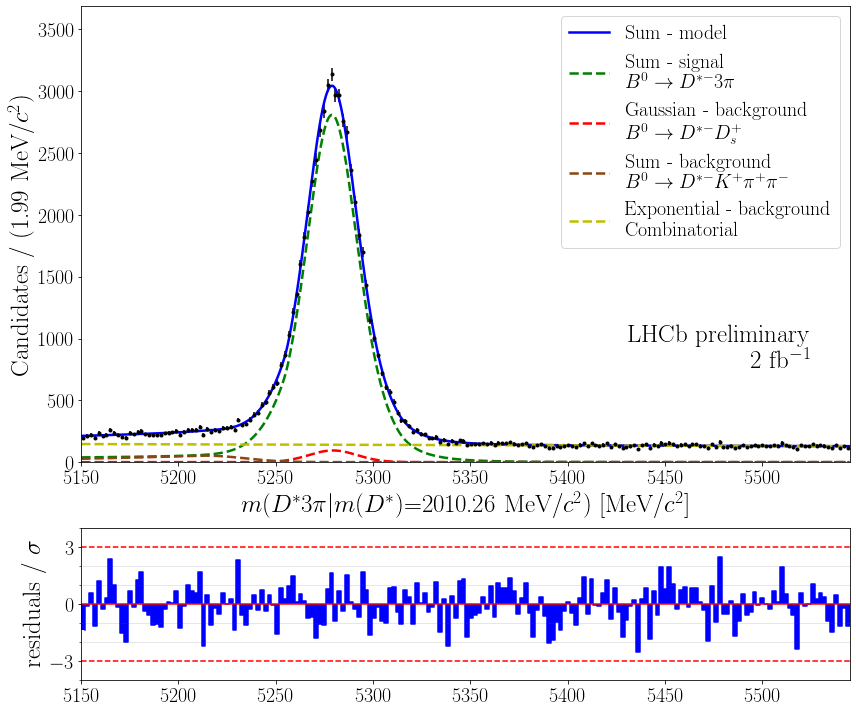

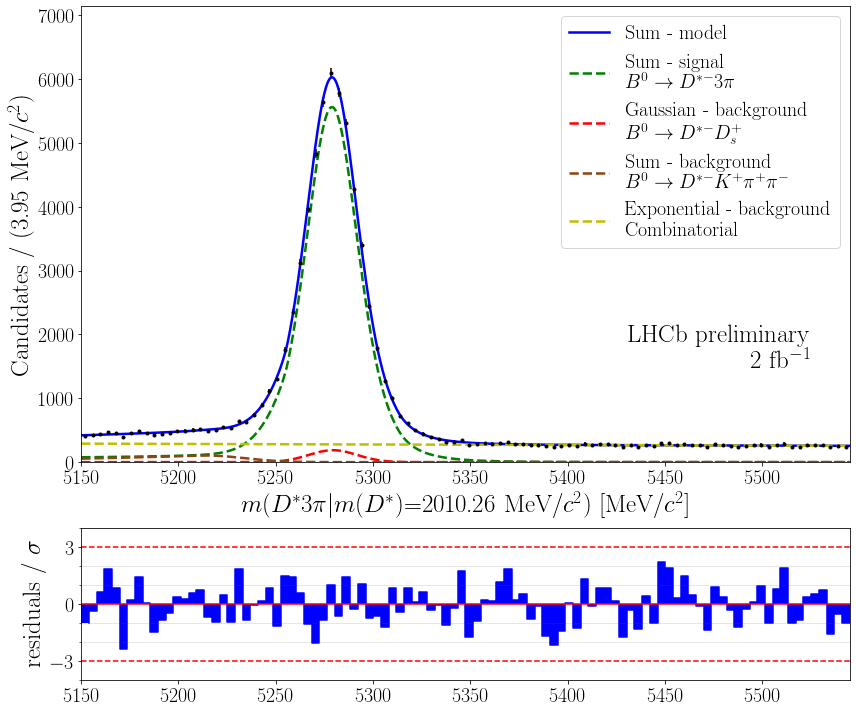

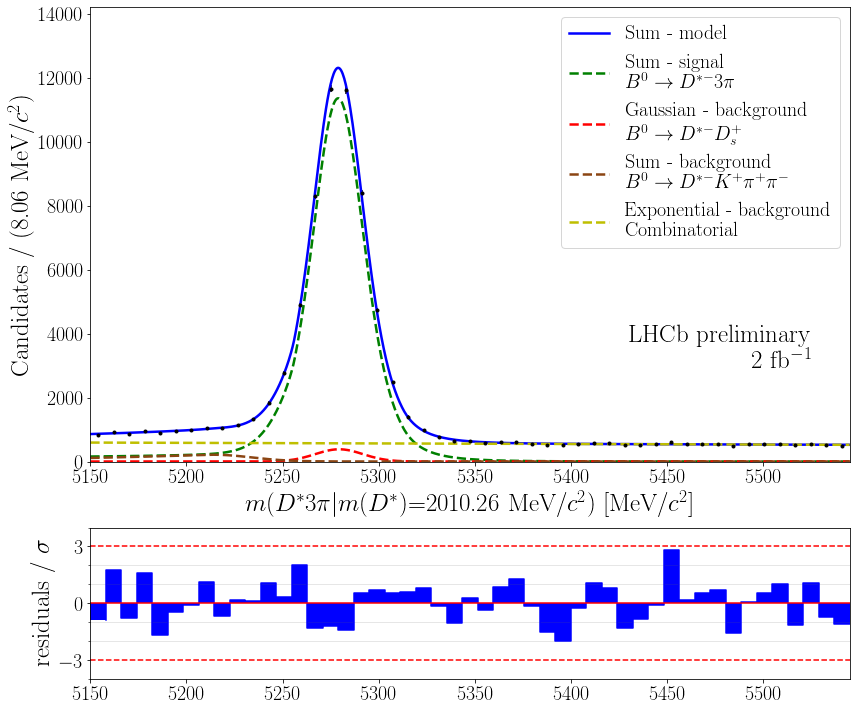

In [19]:
bin_width = 2
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)
data_name_plot = data_name + f'_{bin_width}'
plot_hist_fit_auto(df, branch, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      models_names = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = n_bins,bar_mode = False,  
                       data_name = data_name_plot, folder_name=data_name,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'])

bin_width = 4
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)
data_name_plot = data_name + f'_{bin_width}'
plot_hist_fit_auto(df, branch, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      models_names = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,bar_mode = False, 
                       data_name = data_name_plot, folder_name=data_name,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'])

bin_width = 8
n_bins = np.rint(np.round(high-low)/bin_width).astype(int)
data_name_plot = data_name + f'_{bin_width}'
plot_hist_fit_auto(df, branch, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      models_names = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = n_bins,bar_mode = False,
                       data_name = data_name_plot, folder_name=data_name,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'])

In [20]:
save_params(params,data_name, True, folder_name=data_name)

Json file saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_B0TODst3pi_Dst_constr/common_B0TODst3pi_Dst_constr_params.json


### Latex table

In [21]:
json_to_latex_table(data_name, data_name, latex_params)

Latex table in /afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0TODst3pi_Dst_constr/common_B0TODst3pi_Dst_constr_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\alpha_{L, S}$&$2.03\pm0.11$\\
\hline
$\alpha_{R, S}$&$-1.78\pm0.13$\\
\hline
$f_{\frac{L}{R}}$&$0.461\pm0.041$\\
\hline
$\lambda_{B,c}$&$-0.00032\pm0.00019$\\
\hline
$\mu_S$&$5278.904\pm0.093$\\
\hline
$n_{L_S}$&$0.44\pm0.13$\\
\hline
$n_{B,c}$&$(2.725\pm0.065)\times 10^4$\\
\hline
$n_S$&$(5.45\pm0.12)\times 10^4$\\
\hline
$\frac{n_{B,D^*K\pi\pi}}{n_S}$&$0.035\pm0.015$\\
\hline
$\sigma_{L, S}$&$11.12\pm0.35$\\
\hline
$\sigma_{R, S}$&$18.91\pm0.59$\\
\hline
\end{tabular}


In [22]:
fitted_params = retrieve_params(data_name, folder_name=data_name)

In [23]:
fitted_params

{'alphaL': 2.02992217591786,
 'alphaL_err': 0.10980586561515908,
 'alphaR': -1.7778067363088699,
 'alphaR_err': 0.12545905968984256,
 'frac': 0.4606028157425781,
 'frac_err': 0.041060193019851816,
 'lambda': -0.00031656424152579944,
 'lambda_err': 0.00018681730198464563,
 'mu': 5278.903504161471,
 'mu_err': 0.09292785262851301,
 'nL': 0.4354740104546931,
 'nL_err': 0.13466612140871526,
 'n_bkg': 27254.272275304225,
 'n_bkg_err': 653.8038852080741,
 'n_sig': 54484.3847590686,
 'n_sig_err': 1232.6517679226226,
 'r_bkgK': 0.035341458516519916,
 'r_bkgK_err': 0.015371596845940722,
 'sigmaL': 11.122899161603481,
 'sigmaL_err': 0.3465565844307582,
 'sigmaR': 18.90891531621809,
 'sigmaR_err': 0.5910225019441315}

## Quality of the fit

In [15]:
from HEA.plot.histogram import get_count_err
from HEA.plot import plot_x_list_ys
from HEA.fit.PDF import get_n_dof_model, get_reduced_chi2
import HEA.plot.tools as pt

In [16]:
l_n_bins = [50, 100, 200, 500, 800, 1000]

In [17]:
l_ndof = []
l_mean = []
l_std  = []
l_chi2 = []
l_bin_width = []

In [18]:
data = df[branch]

In [19]:
for n_bins in l_n_bins:
    print(n_bins)
    counts, _, centres, err = get_count_err(data, n_bins, low, high, weights=None)
    
    plot_scaling = counts.sum() * (high-low) / n_bins
    fit = model.pdf(centres).numpy() * plot_scaling
    
    with np.errstate(divide='ignore', invalid='ignore'): # ignore divide-by-0 warning
        pull = np.divide(counts-fit,err)
    
    ndof = get_n_dof_model(model)
    
    mean = np.mean(pull)
    std  = np.std(pull)
    chi2 =get_reduced_chi2(fit, counts, ndof)
    
    l_ndof.append(ndof)
    l_mean.append(mean)
    l_std.append(std)
    l_chi2.append(chi2)
    l_bin_width.append(centres[1]-centres[0])

50
100
200
500
800
1000


In [20]:
l_bin_width = np.array(l_bin_width)

In [21]:
l_bin_width_around = np.around(l_bin_width, 1)

In [22]:
l_ndof = np.array(l_ndof)
l_mean = np.array(l_mean)
l_std = np.array(l_std)
l_chi2 = np.array(l_chi2)

In [23]:
l_n_bins

[50, 100, 200, 500, 800, 1000]

Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/mean_residuals_vs_number_bins


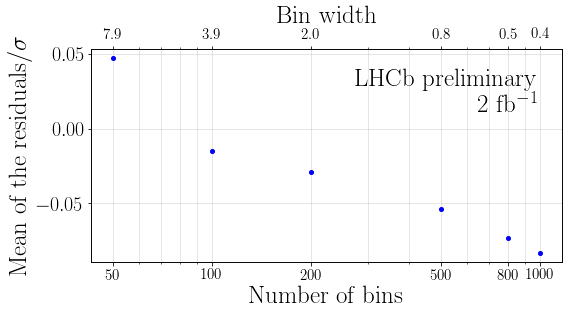

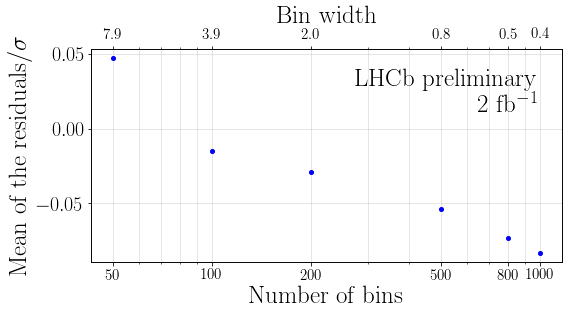

In [24]:
fig, ax = plot_x_list_ys(l_n_bins, l_mean, 'Number of bins', 
               ['Mean of the residuals$/\sigma$'],
               folder_name=data_name, pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., log_scale='x',
                fig_name='mean_residuals_vs_number_bins', save_fig=False)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins)
ax.tick_params(axis='x', labelsize=15)

pt.save_fig(fig, fig_name='mean_residuals_vs_number_bins', folder_name=data_name)
fig

Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/std_residuals_vs_number_bins


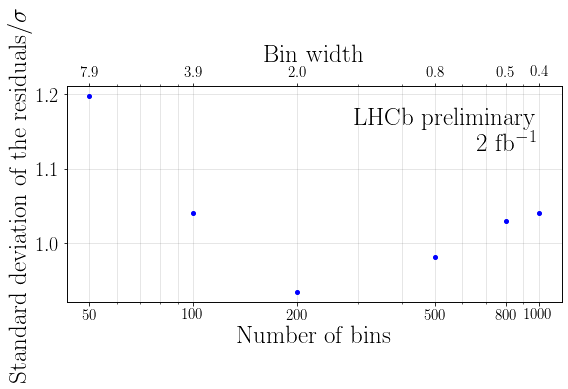

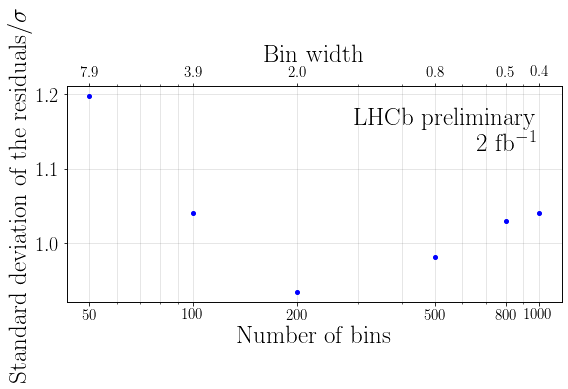

In [25]:
fig, ax = plot_x_list_ys(l_n_bins, l_std, 'Number of bins', 
               ['Standard deviation of the residuals$/\sigma$'],
               folder_name=data_name, pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., log_scale='x',
                fig_name='std_residuals_vs_number_bins', save_fig=False)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins)
ax.tick_params(axis='x', labelsize=15)

pt.save_fig(fig, fig_name='std_residuals_vs_number_bins', folder_name=data_name)
fig

Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr/reduced_chi2_vs_number_bins


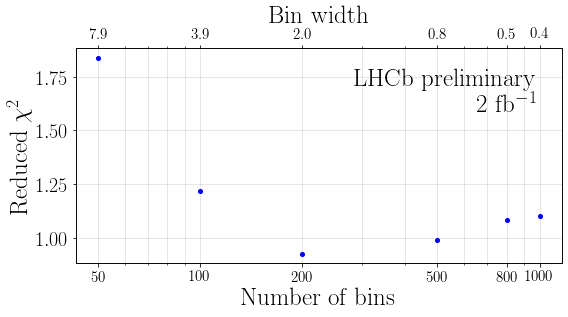

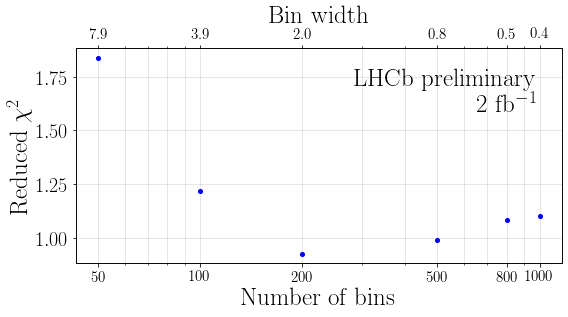

In [26]:
fig, ax = plot_x_list_ys(l_n_bins, l_chi2, 'Number of bins', 
               ['Reduced $\\chi^2$'],
               folder_name=data_name, pos_text_LHC=[0.95, 0.9, 'right'],
                linestyle='', marker='o', markersize=4., log_scale='x',
                fig_name='reduced_chi2_vs_number_bins', save_fig=False)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xscale('log')

ax2.set_xticks(l_n_bins)
ax2.set_xticklabels(l_bin_width_around)
ax2.tick_params(axis='x', labelsize=15)
ax2.set_xlabel("Bin width", fontsize=25)

ax.set_xticks(l_n_bins)
ax.set_xticklabels(l_n_bins)
ax.tick_params(axis='x', labelsize=15)

pt.save_fig(fig, fig_name='reduced_chi2_vs_number_bins', folder_name=data_name)
fig

## Comparison to world-average branching ratios

### Compute the misidentified $K$ rate

$$\mathcal{B}\left(B^0 \to D^{*-} \pi^+ \pi^- \pi^-\right) = (7.21 \pm 0.29)\times 10^{-3}$$
$$\mathcal{B}\left(B^0 \to D^{*-} K^+ \pi^- \pi^-\right) = (4.7 \pm 0.4)\times 10^{-4}$$


In [30]:
from uncertainties import ufloat
fitted_params = retrieve_params(data_name, folder_name=data_name)

### $\frac{\mathcal{B}(B^0\to D^*K \pi \pi)}{\mathcal{B}(B^0\to D^* \pi \pi \pi)}$, from the fit

In [31]:
normal_mode_br = ufloat(7.21e-3, 0.29e-3)
bkgK_br = ufloat(4.7e-4, 0.4e-4)
print(bkgK_br/normal_mode_br)

0.065+/-0.006


### $\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}$, from the fit

In [32]:
r_bkgK = ufloat(fitted_params['r_bkgK'],fitted_params['r_bkgK_err'])
print(r_bkgK)

0.035+/-0.015


### misidentified K rate
It is equal to:
$$\frac{\frac{n_{B^0\to D^*K \pi \pi}}{n_{B^0\to D^* \pi \pi \pi}}}{\frac{\mathcal{B}(B^0\to D^*K \pi \pi)}{\mathcal{B}(B^0\to D^* \pi \pi \pi)}}$$

In [33]:
r_bkgK/(bkgK_br/normal_mode_br)

0.5421530125619332+/-0.24126613364258498

### Compare $B^0 \to D^* D_s$ and $B^0 \to D^* (D_s \to 3\pi)$
$$\mathcal{B}\left(B^0 \to D^{*-} D_s \right) = (8.0 \pm 1.1)\times 10^{-3}$$
$$\mathcal{B}\left(D_{s}^+ \to \pi^+ \pi^+ \pi^- \right) = (1.08 \pm 0.04)\times 10^{-2}$$

### $\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}$, from the PDG

In [34]:
bkgDs_br = ufloat(8.0e-3, 1.1e-3)*ufloat(1.08e-2, 0.04e-2)
print(bkgDs_br/normal_mode_br)
r_br_Ds = bkgDs_br/normal_mode_br

0.0120+/-0.0018


### $\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}$, from the fit

In [35]:
fitted_params_Ds = retrieve_params(data_name_B0toDstDs, folder_name=data_name_B0toDstDs)

In [36]:
n_bkgDs = ufloat(fitted_params_Ds['n_sig_DstDs'], fitted_params_Ds['n_sig_DstDs_err'])

In [37]:
n_normal_mode = ufloat(fitted_params['n_sig'],fitted_params['n_sig_err'])

In [38]:
r_bkgDs = n_bkgDs/n_normal_mode
print(r_bkgDs)

0.0269+/-0.0010


### $\frac{\frac{n_{B^0\to D^*D_s}}{n_{B^0\to D^*3\pi}}}{\frac{\mathcal{B}(B^0\to D^*D_s)}{\mathcal{B}(B^0\to D^*3\pi)}}$

In [39]:
print(r_bkgDs/r_br_Ds)

2.25+/-0.34
